In [44]:
import getpass
import os
import json
import random
import pandas as pd
from collections import Counter
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

from langchain_mistralai import ChatMistralAI  # Import Mistral integration
from dotenv import load_dotenv

Main next steps:
- Split client checking VS negotiation initiating 
- Several negotiations processing
- Change status of processed clients
- Send emails to all clients 
- If negotiation was successful -> positive email
-- If unsuccessful -> we didn't find a replacement -> leave it
-- add processing of buyer/seller 

We wil integrate prior buyer's data/their historical behavior/ continuously adapting to negotiating with them 
- New sales people
- Remove bias of employee changes/ emotions

In [2]:
root_path = os.getcwd()
print(root_path)

/Users/nursulusagimbayeva/Downloads/ai_powered_client_maintanence/ai_powered_client_maintanence


Load the LLM

In [3]:
# Load environment variables from .env file
load_dotenv()

True

In [4]:
os.environ["MISTRAL_API_KEY"] = os.getenv('MISTRAL_API_KEY')

In [8]:
# Instantiate the Mistral LLM
llm = ChatMistralAI(
    model="mistral-large-latest",  # Replace with your desired Mistral model
    temperature=0.7,
    max_retries=3,
)

In [6]:
### Read id to product
with open('data/id_to_product.json', 'r') as f:
    id_to_product = json.load(f)

In [7]:
### Read id to product
with open('data/product_to_vendor.json', 'r') as f:
    product_to_vendor = json.load(f)

In [10]:
# Graph state
class State(TypedDict):
    clients_requests: pd.DataFrame
    vendors: pd.DataFrame
    company_negotiation_msg: str
    vendor_negotiation_msg: str
    negotiation_decision_company: str # decision of the company [accept_offer, keep_negotiation, reject_offer]
    negotiation_decision_vendor: str # decision of the vendor [accept_offer, keep_negotiation, reject_offer]
    send_confirmation_email: bool # whether we send an email to the client
    start_negotiation: bool
    message_to_the_client: str # for generating an email to client
    current_client: str # for generating an email to client
    product_id: int # what product are we talking about
    date_of_request: str # for generating an email to client
    negotiation_requests: dict # a collection of negotiation requests to process
    negotiation_attempts: int # number of attempts to negotiate 
    agreement_reached: bool
    company_offer: str
    vendor_offer: str
    # TODO: need to save a list of clients affected by negotiation
    # TODO: can we do negotations in parallel 
    # TODO: add a notification/status that human intervention is needed

TODO: add calendly invite to the user email

TODO: emergency scale

In [19]:
state['clients_requests']

NameError: name 'state' is not defined

In [60]:
df = pd.read_csv("data/client_requests.csv")

In [61]:
df

,Emergency,Client ID,Customer,Client email,Product,Date of request,Solved
0,yes,6a688622,yes,trivas@example.net,3,2025-01-01,False
1,yes,e16121b3,yes,stephen16@example.com,6,2025-01-01,False
2,no,47585dcc,yes,gomezallison@example.org,5,2025-01-01,False
3,yes,c5dbc779,yes,patrick76@example.org,1,2025-01-03,False
4,yes,88b6e3ac,yes,hector88@example.com,8,2025-01-03,False
...,...,...,...,...,...,...,...
95,no,738138e5,no,sarahtaylor@example.net,3,2025-02-25,False
96,no,992cd1bc,no,fernandezbrett@example.com,3,2025-02-25,False
97,yes,b1cf0ef7,no,brenda20@example.org,3,2025-02-26,False
98,yes,e60c59c2,no,annascott@example.org,2,2025-02-27,False


In [21]:
df.iloc[-1]['Product']

np.int64(2)

In [51]:
# Nodes
# def get_product_request(state: State):

def load_dataframe(state: State):
    ### TODO: replace with the access to the database
    """Loads the DataFrame at the start of the workflow."""
    print('loading dataframes')
    df = pd.read_csv("data/client_requests.csv")  # Load your dataset
    df_vendors = pd.read_csv("data/vendors.csv")
    return {"clients_requests": df, 'vendors': df_vendors}

def load_last_client(state: State):
    """Loads the last client data."""
    print('loading last client')
    ### TODO: add a case when the last clients request was already processed -> write something like "Already solved"
    data = state['clients_requests']
    product_id = data.iloc[-1]['Product']
    client_id = data.iloc[-1]['Client ID']
    date_of_request = data.iloc[-1]['Date of request']
    return {"product_id": product_id, 'current_client': client_id, 'date_of_request': date_of_request}
    
def update_dataframe(state: State):
    """Updates the DataFrame with new information."""
    df = state["df"]  # Access the dataframe
    new_row = {"column1": "value1", "column2": "value2"}  # Example update
    df = df.append(new_row, ignore_index=True)  # Update it
    return {"clients_requests": df}  # Return the updated DataFrame

def check_inventory(state: State):
    """Check if there is inventory in stock"""
    print('checking the inventory')
    vendors = state['vendors']
    product_id = state['product_id']
    df_product_vendor = vendors[vendors['Product ID'] == product_id]
    if df_product_vendor['inventory'].iloc[0] > 5: 
        return {"send_confirmation_email": True, "start_negotiation": False}
    elif 5 >= df_product_vendor['inventory'].iloc[0] > 0: 
        return {"send_confirmation_email": True, "start_negotiation": True}
    
    ### TODO: Make it recursive/ more beautiful
    else:
        # if the replacement is available, but the current product is out of stock -> start negotiation for current product_ID 
        # TODO: might need to negotiation for several missing/deficite products
        if str(vendors[vendors["Product ID"] == int(df_product_vendor['Replacement'])]['inventory'].iloc[0]) == 'nan': 
            return {"send_confirmation_email": False, "start_negotiation": True}
        else: 
            return {"send_confirmation_email": True, "start_negotiation": True}
        
def check_send_confirmation_email(state):
    print('check_send_confirmation_email')

    return "write_email" if state.get("send_confirmation_email") else "not_write_email"

def check_start_negotiation(state):
    print('check_start_negotiation')
    return "starting_negotiation" if state.get("start_negotiation") else "not_start_negotiation"

# Nodes
def generate_email_client(state: State):
    # TODO: ugly (str(int()))
    """Write an email to the client confirming the order and specifying the expected time"""
    print('generate_email_client')
    email = f'''Dear Client {state['current_client']},
    
    We are writing to provide you with an update on your maintenance request from {state['date_of_request']}.

    The status for f{id_to_product[str(int(state['product_id']))]} has been updated to: COMPLETED
    Last Updated: 3/15/2025

    Please don't hesitate to contact us if you have any questions.

    Best regards,
    Maintenance Team
    '''
    return {"message_to_the_client": email}


def process_data_for_negotiation(state: State):
    '''
    Prepare negotiation requests.
    '''
    print('process_data_for_negotiation')
    data = state['clients_requests']
    data["Solved"] = data["Solved"].astype(bool)
    unsolved_data = data[data["Solved"] == False]
    # Aggregate by Product (counting the number of requests per product)
    aggregated_df = unsolved_data.groupby("Product").agg(lambda x: list(x)).reset_index()
    
    negotiation_requests = dict()
    for product in aggregated_df['Product']:
        df_product = aggregated_df[aggregated_df['Product'] == product]
        volume = len(df_product['Client ID'].iloc[0])
        negotiation_requests[product] = {
            'volume': volume,
            'emergency': round(Counter(df_product['Emergency'].iloc[0])['yes']/volume*100, 1),
            'customers_affected': list(df_product['Client ID'].iloc[0]),
            'dates_of_request': list(df_product['Date of request'].iloc[0])
        }
        
    return {'negotiation_requests': negotiation_requests}
    
    
### TODO: Create a separate CSV - temporary
### Add a column - Solved/Unsolved
def starting_negotiation(state: State):
    print('starting_negotiation')
    # Aggregate for the temporary table
    # Unsolved - aggregate based on each product 
    # Get urgency, Volume

    # input: urgency, volume, rest 
    # TODO: think of more factors to include
    # TODO: next step = Weights - input from the manager 
    # What criteria we need to stop the negotiation?
    # 
    # TODO: next step = several decision participants 
    # 
    negotiation_requests = state['negotiation_requests']
    # TODO: implement parallel processing of requests. for now testing one
    last_request = list(negotiation_requests.items())[-1]
    
    print('last negotiation request', last_request)
    prompt_start_negotiation = f'''You are an expert procurement negotiator specializing in heating equipment. Your goal is to secure the best possible deal from a vendor while maintaining a professional and cooperative relationship. We are negotiating the purchase of heating equipment, and here are the details of our current offer and the vendor's counteroffer:

    Our Offer:

    Quantity: {last_request[1]['volume']} units
    Price: 100 per unit
    Delivery Terms: Within 2 weeks
    Emergency: {last_request[1]['emergency']}%

    Identify key leverage points (bulk discount, long-term partnership, competitor pricing, urgency of demand).
    Politely push for a better price while keeping the conversation collaborative.
    If price flexibility is limited, negotiate on other terms (faster delivery, better warranty, payment flexibility, additional services).
    Maintain a professional yet firm tone to maximize savings while ensuring a smooth business relationship.
    Your Task:
    Draft a professional yet assertive response to the vendor, proposing a revised deal that meets our objectives while addressing their concerns. If the vendor remains firm on pricing, explore alternative concessions that benefit us."
    '''
    msg = llm.invoke(prompt_start_negotiation)
    # TODO: gmail
    # Output: 
    # offer. 
    # keep negotiating
    # Reject - stop negotiation.
    # human in the loop - human receives a notification - negotiate again.
    # if vendor accepted our offer -> update stock; send email to the user (if required);  track our profits 
    # long time Customers
    # TODO: separate CSV file with our deals. 
    # OUTPUT: decision_company, content_negotiation_company
    print('company_negotiation_msg', msg)
    
    return {'company_negotiation_msg': msg}

# def parse_numbers:
#     ''' parse offer and return offer '''

def response_vendor(state: State):
    '''
    if company Accepts an offer -> stop/confirm
    if company keeps negotiation -> bargain/ reject
    if company rejects -> deal closed  
    '''
    print('response_vendor')
    # OUTPUT: decision_vendor, content_negotiation_vendor
    
    # Increment the negotiation count
    state["negotiation_attempts"] = state.get("negotiation_attempts", 0) + 1
    
    # Simulate agreement condition (Modify logic based on real negotiation)
    # TODO: write actual conditions 
    agreement = random.choice([True, False])  # Simulated outcome
    
    print('agreement', agreement)
    if agreement:
        return {"agreement_reached": True}  # Agreement reached, exit loop
    elif state["negotiation_attempts"] >= 3:
        return {"agreement_reached": False}  # Max attempts reached, exit loop
    
    return {}  # Continue the loop

def company_negotiation(state: State):
    '''
    if company Accepts an offer -> stop/confirm
    if company keeps negotiation -> bargain/ reject
    if company rejects -> deal closed  
    '''    
    print('company_negotiation')
    # Increment the negotiation count
    state["negotiation_attempts"] = state.get("negotiation_attempts", 0) + 1
    
    # Simulate agreement condition (Modify logic based on real negotiation)
    # TODO: write actual conditions 
    agreement = random.choices([True, False], weights=[80, 20], k=1)[0]
    
    print('company_negotiation agreement', agreement)
    if agreement:
        return {"agreement_reached": True}  # Agreement reached, exit loop
    elif state["negotiation_attempts"] >= 3:
        return {"agreement_reached": False}  # Max attempts reached, exit loop
    
    return {}  # Continue the loop
    
# def deal_closed(state: State)

Workflow

In [ ]:
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": "stop"}
)


Here I want to check if state['send_confirmation_email'] is True or False.
If it is True, I want to call improve_joke, if False - call function stop. How to change the code

NameError: name 'workflow' is not defined

In [64]:
list({"a": {"b": 'c'}}.items())[-1]

('a', {'b': 'c'})

In [ ]:
negotiation_requests.items()[-1]

In [52]:
# Build workflow
print('start')
workflow = StateGraph(State)

# Add nodes
print('add nodes')
workflow.add_node("load_dataframe", load_dataframe)  # Load DataFrame first
workflow.add_node("load_last_client", load_last_client)  # Load DataFrame first
workflow.add_node("check_inventory", check_inventory)
workflow.add_node("check_send_confirmation_email", check_send_confirmation_email)
workflow.add_node("check_start_negotiation", check_start_negotiation)
workflow.add_node("generate_email_client", generate_email_client)
workflow.add_node('process_data_for_negotiation', process_data_for_negotiation)
workflow.add_node("starting_negotiation", starting_negotiation)
workflow.add_node("company_negotiation", company_negotiation)
workflow.add_node("response_vendor", response_vendor)
# workflow.add_node("parse_numbers", parse_numbers)


# Add edges to connect nodes

# Start by processing the last client data
print('add edges')
# Start by loading the dataframe
workflow.add_edge(START, "load_dataframe")
# After loading, check the inventory 
workflow.add_edge("load_dataframe", "load_last_client")
workflow.add_edge("load_last_client", "check_inventory")
workflow.add_conditional_edges(
    "check_inventory", check_send_confirmation_email, {"write_email": "generate_email_client", "not_write_email": 'starting_negotiation'}
)   
workflow.add_conditional_edges(
    "check_inventory", check_start_negotiation, {"starting_negotiation": "process_data_for_negotiation", "not_start_negotiation": END}
)        
workflow.add_edge("process_data_for_negotiation", "starting_negotiation")

workflow.add_edge("starting_negotiation", "response_vendor")
# TODO: add parsing deals numbers
# workflow.add_edge("parse_deals", "response_vendor")

workflow.add_conditional_edges(
    "response_vendor",
    lambda state: "generate_email_client" if state["agreement_reached"] else (
        END if state["negotiation_attempts"] >= 3 else "company_negotiation"
    ),
    {"generate_email_client": "generate_email_client", END: END, "company_negotiation": "company_negotiation"}
)

# After company negotiation, parse new deal terms before going back to the vendor
# workflow.add_edge("company_negotiation", "parse_deals")

# Continue to contract signing if agreement is reached
# workflow.add_edge("sign_a_contract", END)


workflow.add_edge("generate_email_client", END)

# Compile
print('compile')
chain = workflow.compile()

print('display')
# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

start
add nodes
add edges
compile
display


ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)

In [57]:
chain.get_graph().draw_mermaid()

"%%{init: {'flowchart': {'curve': 'linear'}}}%%\ngraph TD;\n\t__start__(<p>__start__</p>)\n\tload_dataframe(load_dataframe)\n\tload_last_client(load_last_client)\n\tcheck_inventory(check_inventory)\n\tcheck_send_confirmation_email(check_send_confirmation_email)\n\tcheck_start_negotiation(check_start_negotiation)\n\tgenerate_email_client(generate_email_client)\n\tprocess_data_for_negotiation(process_data_for_negotiation)\n\tstarting_negotiation(starting_negotiation)\n\tcompany_negotiation(company_negotiation)\n\tresponse_vendor(response_vendor)\n\t__end__(<p>__end__</p>)\n\t__start__ --> load_dataframe;\n\tgenerate_email_client --> __end__;\n\tload_dataframe --> load_last_client;\n\tload_last_client --> check_inventory;\n\tprocess_data_for_negotiation --> starting_negotiation;\n\tstarting_negotiation --> response_vendor;\n\tcheck_inventory -. &nbsp;write_email&nbsp; .-> generate_email_client;\n\tcheck_inventory -. &nbsp;not_write_email&nbsp; .-> starting_negotiation;\n\tcheck_inventory 

In [59]:
initial_state = State({
    "agreement_reached": False,  
    "negotiation_attempts": 0,  
    # Add any other necessary keys and initial values
})

final_state = chain.invoke(initial_state)


loading dataframes
loading last client
checking the inventory
check_send_confirmation_email
check_start_negotiation
generate_email_client
process_data_for_negotiation
starting_negotiation
last negotiation request (8, {'volume': 15, 'emergency': 40.0, 'customers_affected': ['88b6e3ac', '1f75dfc9', '268d3da5', '3b593322', 'fa359306', '4717e8d9', '8448c47f', '4437c510', '94c42503', '553a4615', '69333c71', '70903be5', 'f0a70d01', 'ba33778f', '04a6b77a'], 'dates_of_request': ['2025-01-03', '2025-01-03', '2025-01-04', '2025-01-11', '2025-01-18', '2025-01-20', '2025-01-30', '2025-01-31', '2025-02-02', '2025-02-10', '2025-02-12', '2025-02-13', '2025-02-18', '2025-02-20', '2025-02-21']})
company_negotiation_msg content="Dear [Vendor's Name],\n\nThank you for your prompt response and the counteroffer for our heating equipment inquiry. We appreciate your willingness to work with us and would like to continue our dialogue to reach a mutually beneficial agreement.\n\nFirstly, we understand that the

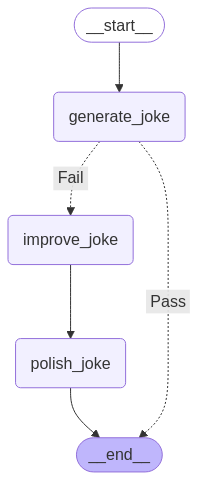

Initial joke:
What do you call a cat that lives in an igloo? An eskimew.

--- --- ---

Improved joke:
What do you call a cat that lives in an igloo? A purr-mafrost eskimew!

--- --- ---

Final joke:
What do you call a cat that lives in an igloo? A purr-mafrost eskimew! And what do you call it when it starts singing? A mew-sical ice-olation!


In [18]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")